In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm

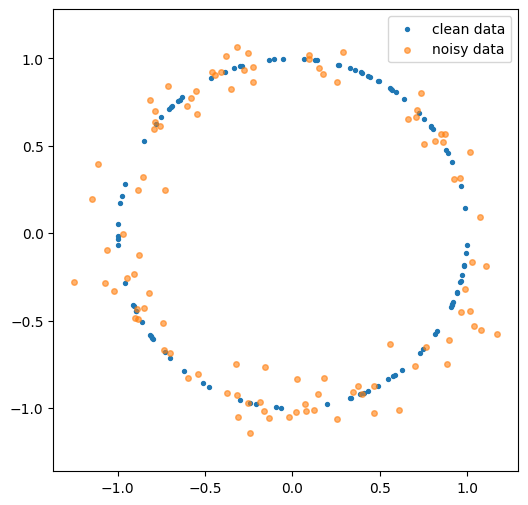

In [2]:
import tadasets
np.random.seed(565656)

data_clean = tadasets.dsphere(d=1, n=100, noise=0.0)
data_noisy = tadasets.dsphere(d=1, n=100, noise=0.10)

# data_clean = tadasets.infty_sign(n=100, noise=0.0)
# data_noisy = tadasets.infty_sign(n=100, noise=0.15)

plt.rcParams["figure.figsize"] = (6, 6)
plt.scatter(data_clean[:,0], data_clean[:,1], label="clean data", s=8)
plt.scatter(data_noisy[:,0], data_noisy[:,1], label="noisy data", s=16, alpha=0.6)
plt.axis('equal')
plt.legend()
plt.show()

In [3]:
import ripser
import persim

def diagram_sizes(dgms):
    return ", ".join([f"|$H_{i}$|={len(d)}" for i, d in enumerate(dgms)])

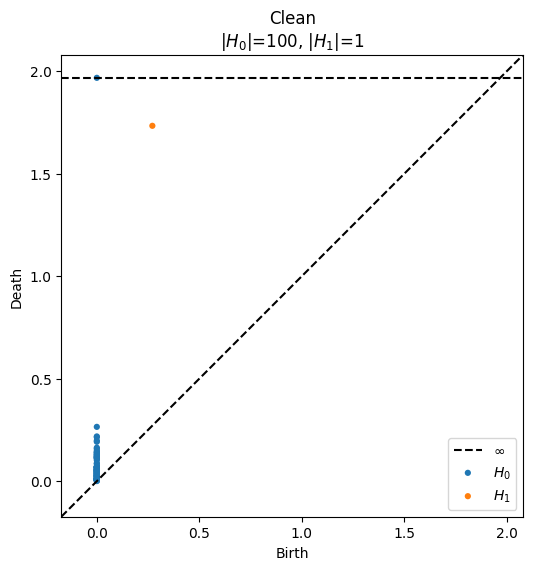

In [4]:
dgm_clean = ripser.ripser(data_clean)['dgms']
persim.plot_diagrams(
    dgm_clean,
    show=True,
    title=f"Clean\n{diagram_sizes(dgm_clean)}"
)

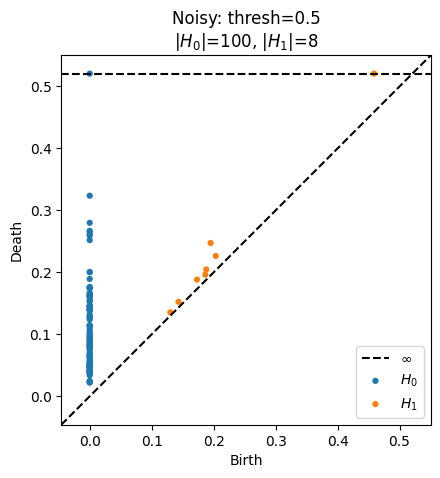

In [5]:
thresh = 0.5
dgm_noisy = ripser.ripser(data_noisy, thresh=thresh)['dgms']
persim.plot_diagrams(
    dgm_noisy, show=True,
    title=f"Noisy: thresh={thresh}\n{diagram_sizes(dgm_noisy)}"
)

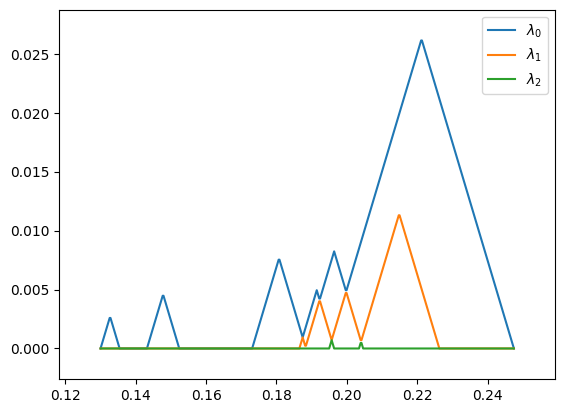

In [8]:
from persim import PersLandscapeApprox, PersLandscapeExact
from persim.landscapes import plot_landscape_simple

pla = PersLandscapeApprox(dgms=dgm_noisy,hom_deg=1)
ax = plot_landscape_simple(pla, depth_range=range(10))